Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# Efeito de segunda ordem na frequência fundamental de torres esbeltas

[1.   Introdução](#section_1)  
[2.   Soluções analíticas exatas e aproximadas](#section_2)  
[3.   Solução numérica com matrix de rigidez geométrica](#section_3)  
[4.   Modelo experimental](#section_4)  
[5.   Comparação de resultados](#section_5)  
[6.   Conclusões](#section_6)  

---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Porto Alegre, RS, Brazil_ 


In [49]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import numpy as np
import matplotlib.pyplot as plt
import pickle as pk

# Module for system matrices calculation
from  FEM_column import *


## 1. Introdução <a name="section_1"></a> 

1. A principal carga em torres é o vento.
2. Torres esbeltas tem resposta ressonante importante.
3. A resposta ressonante depende da frequência fundamental da torre.
4. Algumas torres tem grande massa adicionada ao topo (mirantes, antenas, etc.)
5. Massas adicionais causam um efeito de segunda ordem na resposta em vibração livre.
6. Neste caso resposta dinâmica à ação do vento deve considerar uma frequência reduzida.


## 2. Soluções analíticas aproximadas <a name="section_2"></a> 

### 2.1. Solução exata para a barra de seção constante  <a name="section_21"></a> 

Para torres esbeltas de seção constante é conhecida a solução analítica para a 
frequência natural de vibração livre associada ao modo fundamental:

$$ f_{\rm n} = \frac{1}{2\pi} \left( \frac{1.8751}{H} \right)^2 \sqrt{\frac{EI}{\mu}} $$

onde H é a altura da torre, $EI$ é a rigidez à flexão, e $\mu$ é a massa por unidade
de comprimento. A constante 1.8751 é aproximada e consiste na menor raiz não nula e 
positiva, $a$, da equação característica:

$$ \cos(a) \cosh(a) + 1 = 0 $$

As demais soluções positivas estão associadas à modos superiores que não serão 
considerados neste trabalho. 

A frequência fundamental pode ser calculada com esta fórmula para as três hastes 
de alumínio com seção transversal 2cm $\times$ 0,5mm e com comprimentos 22, 30 e 38cm, 
respectivamente, que são utilizadas na parte experimental deste trabalho. Assim temos:


In [50]:
# Seção transversal em alumínio
EI  =   7.2e10*(0.020*0.0005**3)/12
mu  =   2.7e03*(0.020*0.0005)

print('Rigidez da seção transversal à flexão: {0:6.4f}Nm²'.format(EI)) 
print('Massa por unidade de comprimento:      {0:6.4f}kg/m'.format(mu)) 


Rigidez da seção transversal à flexão: 0.0150Nm²
Massa por unidade de comprimento:      0.0270kg/m


Aplicando-se então a fórmula para os três comprimentos de haste a serem estudados tem-se:


In [51]:
H22 =   0.22
H30 =   0.30
H38 =   0.38

f0  =   np.sqrt(EI/mu)/(2*np.pi)

f22 = ((1.875/H22)**2)*f0
f30 = ((1.875/H30)**2)*f0
f38 = ((1.875/H38)**2)*f0

print('Frequência fundamental para a haste de 22cm: {0:5.2f}Hz'.format(f22)) 
print('Frequência fundamental para a haste de 30cm: {0:5.2f}Hz'.format(f30)) 
print('Frequência fundamental para a haste de 38cm: {0:5.2f}Hz'.format(f38)) 


Frequência fundamental para a haste de 22cm:  8.62Hz
Frequência fundamental para a haste de 30cm:  4.63Hz
Frequência fundamental para a haste de 38cm:  2.89Hz


É importante lembrar que o resultado acima desconsidera o efeito de segunda ordem 
decorrente do peso próprio da torre ou do acréscimo de qualquer massa adicional.

Como este trabalho tem como objetivo justamente a quantificação do efeito 
de segunda ordem na frequência fundamental, determina-se a seguir as cargas críticas 
de flambagem elástica (carga de Euler) para os três comprimentos de haste utilizados
na parte experimental. 
Estas cargas correspondem ao peso da maior massa que pode ser acrescentada ao topo 
das hastes e serão posteriormente utilizadas como parâmetro de adimensionalização. 


In [52]:
r0  =   0.0005/np.sqrt(12)               # raio de giração
P0  =  (np.pi**2)*7.2E10*(0.020*0.0005)  # numerador da fórmula de Euler

P22 =   P0/(2*H22/r0)**2
P30 =   P0/(2*H30/r0)**2
P38 =   P0/(2*H38/r0)**2

print('Carga crítica para a haste de 22cm: {0:5.3f}N ({1:4.1f}g)'.format(P22, 1000*P22/9.81)) 
print('Carga crítica para a haste de 30cm: {0:5.3f}N ({1:4.1f}g)'.format(P30, 1000*P30/9.81)) 
print('Carga crítica para a haste de 38cm: {0:5.3f}N ({1:4.1f}g)'.format(P38, 1000*P38/9.81)) 


Carga crítica para a haste de 22cm: 0.765N (78.0g)
Carga crítica para a haste de 30cm: 0.411N (41.9g)
Carga crítica para a haste de 38cm: 0.256N (26.1g)


### 2.2. Solução aproximada por quociente de Rayleigh  <a name="section_22"></a> 

Para o cálculo analítico da frequência fundamental com o acréscimo de uma massa no topo
da torre pode ser utilizado o método do quociente de Rayleigh, que representa um 
estimador da frequência natural de vibração livre e é dado pela relação entre a 
energia potencial elástica, $V$,  e a energia cinética de referência, $T_{\rm ref}$:

$$ f_{\rm n} \leq \frac{1}{2\pi} \sqrt{\frac{V}{T_{\rm ref}}} $$

O cálculo destas energias requer a definição de uma função de interpolação para 
a linha elástica, tão próxima quanto possível da forma modal. Por exemplo, a solução 
da linha elástica para uma carga horizontal no topo é muito semelhante ao primeiro
modo de vibração livre:

$$ \varphi(\xi) = \frac{1}{2}\left(3\xi^2 - \xi^3\right)$$

com $\xi = z/H$ sendo a coordenada vertical adimensionalizada. Note-se que esta 
função de interpolação  está normalizada para deslocamento unitário no topo. 
Uma vez escolhida a função $\varphi(\xi)$, as energias $V$ e $T_{\rm ref}$ são 
calculadas como:

\begin{align*}
 V           &= \frac{1}{2} \int_0^H { EI \left[ \varphi^{\prime\prime}(z) \right] ^2 \, dz} \\
 T_{\rm ref} &= \frac{1}{2} \int_0^H {\mu \left[ \varphi(z) \right] ^2 \, dz} 
\end{align*}

Para as três hastes utilizadas na parte experimental deste trabalho as frequências
obtidas por este método estão apresentadas abaixo:


In [53]:
phi  =  lambda z: (3*(z/H)**2 - (z/H)**3)/2   # função de interpolação
ph1  =  lambda z: (6*(z/H) - 3*(z/H)**2)/2/H  # primeira derivada = rotação
ph2  =  lambda z: (6 - 6*(z/H))/2/(H**2)      # segunda derivada = curvatura

n    =  100  # número de segmentos de discretização

H    =  H22
zi   =  np.linspace(0, H22, n)
V    =  np.trapz(ph2(zi)**2, dx=H22/n)*(EI/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H22/n)*(mu/2) 
f22r =  np.sqrt(V/Tr)/(2*np.pi)
er22 = (f22r - f22)*100/f22

H    =  H30
zi   =  np.linspace(0, H30, n)
V    =  np.trapz(ph2(zi)**2, dx=H30/n)*(EI/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H30/n)*(mu/2) 
f30r =  np.sqrt(V/Tr)/(2*np.pi)
er30 = (f30r - f30)*100/f30

H    =  H38
zi   =  np.linspace(0, H38, n)
V    =  np.trapz(ph2(zi)**2, dx=H38/n)*(EI/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H38/n)*(mu/2) 
f38r =  np.sqrt(V/Tr)/(2*np.pi)
er38 = (f38r - f38)*100/f38

print('Frequência fundamental para a haste de 22cm: {0:6.2f}Hz'.format(f22r)) 
print('Erro de aproximação:                         {0:6.2f}% '.format(er22)) 
print('')
print('Frequência fundamental para a haste de 30cm: {0:6.2f}Hz'.format(f30r)) 
print('Erro de aproximação:                         {0:6.2f}% '.format(er30)) 
print('')
print('Frequência fundamental para a haste de 38cm: {0:6.2f}Hz'.format(f38r)) 
print('Erro de aproximação:                         {0:6.2f}% '.format(er38)) 


Frequência fundamental para a haste de 22cm:   8.74Hz
Erro de aproximação:                           1.47% 

Frequência fundamental para a haste de 30cm:   4.70Hz
Erro de aproximação:                           1.47% 

Frequência fundamental para a haste de 38cm:   2.93Hz
Erro de aproximação:                           1.47% 


### 2.3. Quociente de Rayleigh com massas adicionais  <a name="section_23"></a> 

Portanto, o erro é de apenas 1,5% para a função de interpolação proposta, a qual
intencionalmente difere da linha elástica associada ao modo fundamental. 
Contudo, na medida em que se acrescente massa no topo este erro tende a diminuir,
já que as hastes neste caso serão de fato submetida a uma carga inercial 
concentrada no topo, cuja linha elástica tenderá então à função proposta.

A grande vantagem do uso do quociente de Rayleigh é a fácil introdução de massas
adicionais no denominador, as quais devem ser multiplicadas pelos respectivos valores
da função de interpolação nas posições em que se encontram. Por exemplo, uma massa
adicional no topo, $M_1$, deve ser multiplicada pelo valor $\left[\varphi(H/H)\right]^2 = 1^2$
e neste  caso a energia cinética de referência fica:

$$ T_{\rm ref} = \frac{1}{2} \left( \int_0^H {\mu \left[ \varphi(z) \right] ^2 \, dz}
               +  M_1 \cdot 1^2 \right) $$

A título de exemplo, vamos aplicar a equação acima às hastes utilizadas na parte
experimental deste trabalho. Em cada caso admite-se que a massa adicionada no topo
corresponde à 50% da carga crítica de flambagem:


In [54]:
H    =  H22
zi   =  np.linspace(0, H22, n)
V    =  np.trapz(ph2(zi)**2, dx=H22/n)*(EI/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H22/n)*(mu/2) + (0.5*P22/9.81)/2
f22M =  np.sqrt(V/Tr)/(2*np.pi)

H    =  H30
zi   =  np.linspace(0, H30, n)
V    =  np.trapz(ph2(zi)**2, dx=H30/n)*(EI/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H30/n)*(mu/2) + (0.5*P30/9.81)/2
f30M =  np.sqrt(V/Tr)/(2*np.pi)

H    =  H38
zi   =  np.linspace(0, H38, n)
V    =  np.trapz(ph2(zi)**2, dx=H38/n)*(EI/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H38/n)*(mu/2) + (0.5*P38/9.81)/2
f38M =  np.sqrt(V/Tr)/(2*np.pi)

print('Frequência para a haste de 22cm com massa no topo: {0:6.2f}Hz'.format(f22M)) 
print('Frequência para a haste de 30cm com massa no topo: {0:6.2f}Hz'.format(f30M)) 
print('Frequência para a haste de 38cm com massa no topo: {0:6.2f}Hz'.format(f38M)) 


Frequência para a haste de 22cm com massa no topo:   1.62Hz
Frequência para a haste de 30cm com massa no topo:   1.35Hz
Frequência para a haste de 38cm com massa no topo:   1.15Hz


### 2.4. Quociente de Rayleigh com efeito de segunda ordem

Embora o cálculo acima considere, com excelente precisão, a massa adicional presente
no topo de uma torre, ele ainda não inclui o efeito de segunda ordem devido à compressão
decorrente de uma carga compressiva elevada. Para isso é necessário incluir-se também 
uma modificação no cálculo da energia potencial elástica do sistema, de modo a se considerar 
a deformação axial adicional:

$$ V = \frac{1}{2} \left( \int_0^H { EI \left[ \varphi^{\prime\prime}(z) \right] ^2 \, dz}
     - \int_0^H { P  \left[ \varphi^{\prime}(z) \right] ^2 \, dz} \right) $$

onde a segunda integral corresponde ao trabalho realizado pela carga compressiva pelo
encurtamento vertical da torre. Note-se que o sinal negativo (compressão) implica em 
uma redução da frequência natural, sendo que esta tenderá a zero na medida em que a
carga $P$ se aproxima da carga crítica de flambagem.

Aplicando-se esta nova equação às hastes sujeitas à 50% da carga de crítca 
obtem-se os seguintes resultados:


In [55]:
H    =  H22
zi   =  np.linspace(0, H22, n)
V    =  np.trapz(ph2(zi)**2, dx=H22/n)*(EI/2) 
V   -=  np.trapz(ph1(zi)**2, dx=H22/n)*(0.5*P22/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H22/n)*(mu/2) + (0.5*P22/9.81)/2
f22P =  np.sqrt(V/Tr)/(2*np.pi)
ef22 = (f22M - f22P)*100/f22P

H    =  H30
zi   =  np.linspace(0, H30, n)
V    =  np.trapz(ph2(zi)**2, dx=H30/n)*(EI/2) 
V   -=  np.trapz(ph1(zi)**2, dx=H30/n)*(0.5*P30/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H30/n)*(mu/2) + (0.5*P30/9.81)/2
f30P =  np.sqrt(V/Tr)/(2*np.pi)
ef30 = (f30M - f30P)*100/f30P

H    =  H38
zi   =  np.linspace(0, H38, n)
V    =  np.trapz(ph2(zi)**2, dx=H38/n)*(EI/2) 
V   -=  np.trapz(ph1(zi)**2, dx=H38/n)*(0.5*P38/2) 
Tr   =  np.trapz(phi(zi)**2, dx=H38/n)*(mu/2) + (0.5*P38/9.81)/2
f38P =  np.sqrt(V/Tr)/(2*np.pi)
ef38 = (f38M - f38P)*100/f38P

print('Frequência para a haste de 22cm com efeito de 2a ordem: {0:6.2f}Hz'.format(f22P)) 
print('Erro pelo efeito de 2a. ordem:                          {0:6.2f}% '.format(ef22)) 
print('')
print('Frequência para a haste de 30cm com efeito de 2a ordem: {0:6.2f}Hz'.format(f30P)) 
print('Erro pelo efeito de 2a. ordem:                          {0:6.2f}% '.format(ef30)) 
print('')
print('Frequência para a haste de 38cm com efeito de 2a ordem: {0:6.2f}Hz'.format(f38P)) 
print('Erro pelo efeito de 2a. ordem:                          {0:6.2f}% '.format(ef30)) 


Frequência para a haste de 22cm com efeito de 2a ordem:   1.15Hz
Erro pelo efeito de 2a. ordem:                           40.50% 

Frequência para a haste de 30cm com efeito de 2a ordem:   0.96Hz
Erro pelo efeito de 2a. ordem:                           40.50% 

Frequência para a haste de 38cm com efeito de 2a ordem:   0.82Hz
Erro pelo efeito de 2a. ordem:                           40.50% 


Portanto, a não consideração do efeito de segunda ordem para uma carga compressiva
correspondente a apenas 50% da carga crítica implica que a frequência natural das hastes
de seção constante são superestimadas em aproximadamente 40%. 
Uma diferença desta magnitude tem severas implicações nos cálculos das amplitudes de
resposta dinâmica à ação do vento.


## 3. Solução numérica com matriz de rigidez geométrica <a name="section_3"></a> 

### 3.1. Matriz de rigidez elástica  <a name="section_31"></a> 

<table>
 <tr>
   <td><img src="resources/tower.png"    alt="Tower model"    width="240px"/></td>
   <td><img src="resources/element.png"  alt="Finite element" width="240px"/></td>
 </tr>
</table> 


$$ \mathbf{K} = \frac{EI}{L^3} \;
                \left[ \begin{array}{cccc}
                  12 &   6L   &  -12  &  6L   \\
                  6L &   4L^2 &  -6L  &  2L^2 \\
                 -12 &  -6L   &   12  & -6L   \\
                  6L &   2L^2 &  -6L  &  4L^2
                 \end{array} \right] $$


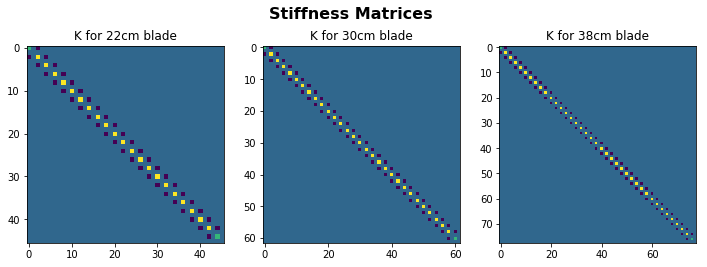

In [56]:
# Discretiza lâminas de alumínio
L22 = 0.01*np.ones(22)
L30 = 0.01*np.ones(30)
L38 = 0.01*np.ones(38)

# Matrizes de rigidez elásticas in N/m
KE22 = stiffness(L22, EI, P=0)
KE30 = stiffness(L30, EI, P=0)
KE38 = stiffness(L38, EI, P=0)

# Visualização das matrizes
fig1, ax = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('Stiffness Matrices', fontweight='bold', fontsize=16)

hax0 = ax[0].imshow(KE22); tax0 = ax[0].title.set_text("K for 22cm blade")
hax1 = ax[1].imshow(KE30); tax1 = ax[1].title.set_text("K for 30cm blade")
hax2 = ax[2].imshow(KE38); tax2 = ax[2].title.set_text("K for 38cm blade")


### 3.2. Matriz de rigidez geométrica <a name="section_32"></a> 

$$ \mathbf{K_{\rm G}} = \frac{P}{30L} \; 
                        \left[ \begin{array}{cccc}
                         36   &  3L    & -36  &  3L   \\
                         3L   &  4L^2  & -3L  & -L^2  \\
                        -36   & -3L    &  36  & -3L   \\
                         3L   & -L^2   & -3L  & 4L^2
                        \end{array} \right] $$


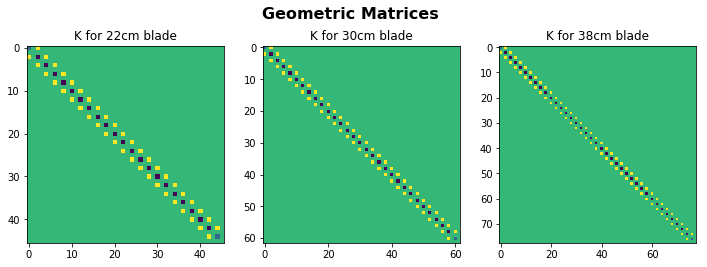

In [57]:
# Matrizes de rigidez geométricas in N/m
KG22 = stiffness(L22, EI=0, P=-P22/2)
KG30 = stiffness(L30, EI=0, P=-P30/2)
KG38 = stiffness(L38, EI=0, P=-P38/2)

# Visualização das matrizes
fig2, ax = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('Geometric Matrices', fontweight='bold', fontsize=16)

hax0 = ax[0].imshow(KG22); tax0 = ax[0].title.set_text("K for 22cm blade")
hax1 = ax[1].imshow(KG30); tax1 = ax[1].title.set_text("K for 30cm blade")
hax2 = ax[2].imshow(KG38); tax2 = ax[2].title.set_text("K for 38cm blade")


Sobrepondo as matrizes elástica e geométrica tem-se a matriz de rigidez com 
efeito de segunda ordem:


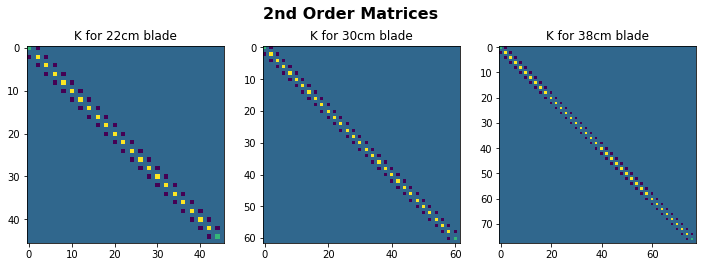

In [58]:
# Matrizes de rigidez geométricas in N/m
K22 = stiffness(L22, EI=EI, P=-P22/2)
K30 = stiffness(L30, EI=EI, P=-P30/2)
K38 = stiffness(L38, EI=EI, P=-P38/2)

# Visualização das matrizes
fig3, ax = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('2nd Order Matrices', fontweight='bold', fontsize=16)

hax0 = ax[0].imshow(K22); tax0 = ax[0].title.set_text("K for 22cm blade")
hax1 = ax[1].imshow(K30); tax1 = ax[1].title.set_text("K for 30cm blade")
hax2 = ax[2].imshow(K38); tax2 = ax[2].title.set_text("K for 38cm blade")


### 3.3. Matriz de massa consistente <a name="section_33"></a> 

$$ \mathbf{M} = \frac{\mu L}{420} \; 
                \left[ \begin{array}{cccc}
                 156  &  22L   &  54   & -13L   \\
                 22L  &  4L^2  &  13L  & -3L^2  \\
                 54   &  13L   &  156  & -22L   \\
                -13L  & -3L^2  & -22L  &  4L^2
                \end{array} \right] $$


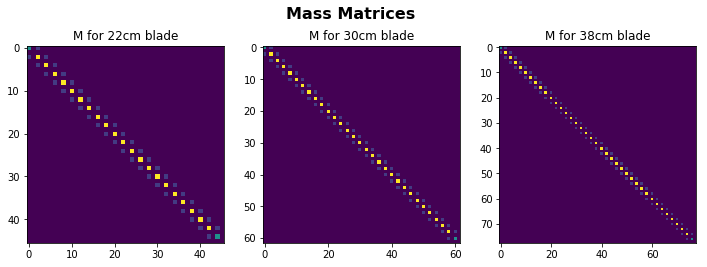

In [59]:
# Consistent masses in kg
M22 = consistMass(L22, mu)
M30 = consistMass(L30, mu)
M38 = consistMass(L38, mu)

# Visualização das matrizes
fig4, ax = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('Mass Matrices', fontweight='bold', fontsize=16)

hax0 = ax[0].imshow(M22); tax0 = ax[0].title.set_text("M for 22cm blade")
hax1 = ax[1].imshow(M30); tax1 = ax[1].title.set_text("M for 30cm blade")
hax2 = ax[2].imshow(M38); tax2 = ax[2].title.set_text("M for 38cm blade")


### 3.4. Estimativa de frequências naturais <a name="section_34"></a> 




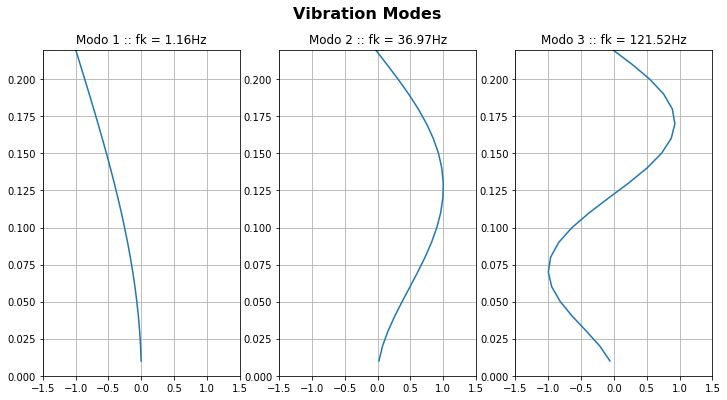

In [60]:
import scipy.linalg as sc

# For L = 22cm
Z22  = L22.cumsum()[::-1]
KT22 = K22[:-2,:-2]
MT22 = M22[:-2,:-2]

MT22[0,0] += 0.5*P22/9.81  # massa adicional no topo é 50% da massa de flambagem

w22, Ph22  =  sc.eig(KT22, MT22)

iw   = w22.argsort()
w22  = w22[iw]
Ph22 = Ph22[:,iw]
wk22 = np.sqrt(np.real(w22)) 
fk22 = wk22/2/np.pi

fig5, ax = plt.subplots(1, 3, figsize=(12,6))
plt.suptitle('Vibration Modes', fontweight='bold', fontsize=16)

for k in range(3):
    
    pk = Ph22[0:-1:2,k]        # retem somente a translação
    pm = np.max(np.abs(pk))    # normaliza máxima amplitude unitária

    ha = ax[k].plot(pk/pm, Z22);
    tx = ax[k].title.set_text('Modo {0} :: fk = {1:4.2f}Hz'.format(k+1,fk22[k]))
    
    ax[k].axis([-1.5, 1.5, 0, Z22[0]])
    ax[k].grid(True)


## 4. Modelo experimental <a name="section_4"></a> 



## 5. Comparação de resultados <a name="section_5"></a> 


